# Intro
We're going to learn how to classify images using machine learning.


## Table of Contents


1. Setup
2. Data Preprocessing
    - a. Create Directories
    - b. Creating Generators
3. Training Model
4. Evaluation
    - a. Evaluation on Test Set
    - b. Visualizing Predictions
    - c. Visualizing Activation Maps
    - d. Visualizing Training Process
5. Data Augmentation
6. Saving
7. Loading
8. Conclusion

## Project Setup
- Import necessary libs
- Do stuff

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp
from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Data Preprocessing

In [13]:
INCLUDE_TEST = True
CAT_DIR = './training_data/Cat'
DOG_DIR = './training_data/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

def make_directories():
  try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
  except OSError:
      print('Error failed to make directory')

# Create directories to hold test data
make_directories()

def view_directories():
  
  print('Sample Data Count:')
  print(f"Training Cats: {len(os.listdir('/tmp/cats-v-dogs/training/cats'))}")
  print(f"Training Dogs: {len(os.listdir('/tmp/cats-v-dogs/training/dogs'))}")

  print(f"Validation Cats: {len(os.listdir('/tmp/cats-v-dogs/validation/cats'))}")
  print(f"Validation Dogs: {len(os.listdir('/tmp/cats-v-dogs/validation/dogs'))}")

  print(f"Test Cats: {len(os.listdir('/tmp/cats-v-dogs/test/cats'))}")
  print(f"TestDogs: {len(os.listdir('/tmp/cats-v-dogs/test/dogs'))}")


# Sanity check: Check the data directories
view_directories()

Error failed to make directory
Sample Data Count:
Training Cats: 11250
Training Dogs: 7222
Validation Cats: 625
Validation Dogs: 401
Test Cats: 625
TestDogs: 402


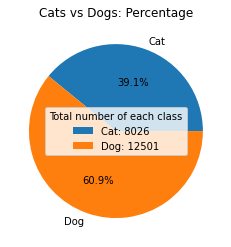

In [14]:
def print_overview():
    class_names = ['Cat', 'Dog'] 
    n_dogs = len(os.listdir(CAT_DIR))
    n_cats = len(os.listdir(DOG_DIR))
    n_images = [n_cats, n_dogs]
    fig, ax = plt.subplots()
    ax.pie(n_images, labels=class_names, autopct='%1.1f%%')
    ax.set_title('Cats vs Dogs: Percentage')
    legend_labels = [f'{class_name}: {n}' for class_name, n in zip(class_names, n_images)]
    ax.legend(legend_labels, title="Total number of each class")
    plt.show()

print_overview()


In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True,  split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files,  len(files))
    split = int(0.9 * len(shuffled_files))
    train = shuffled_files[:split]
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test]
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element),
                 os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element),
                 os.path.join(validation_dir, element))

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element),
                     os.path.join(test_dir, element))
    print("Split successful!")


# Create training/validation data
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats',
           '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats', INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs',
           '/tmp/cats-v-dogs/validation/dogs', '/tmp/cats-v-dogs/test/dogs', INCLUDE_TEST, 0.9)

Split successful!
Split successful!


Create generators

In [8]:
train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

validation_gen =  ImageDataGenerator(rescale=1./255.)
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(rescale=1./255.)
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 18471 images belonging to 2 classes.
Found 1026 images belonging to 2 classes.
Found 1026 images belonging to 2 classes.


The `rescale=1./255.` parameter in the `ImageDataGenerator` will transform images by scaling their pixel values. Here’s a clearer breakdown of what this means:

- **Original Pixel Values**: In a typical image, pixel values range from 0 to 255. These values represent the intensity of each pixel in the image. For example, a pixel value of 0 corresponds to black, and a pixel value of 255 corresponds to white (in grayscale images).

- **Transformation**: The `rescale=1./255.` parameter applies a transformation to these pixel values by multiplying each value by `1/255` (or dividing by 255). This changes the range of pixel values from [0, 255] to [0, 1].

### Example Transformation

1. **Original Image Pixel Values**: 
   ```
   [[0, 128, 255],
    [64,  200, 100]]
   ```

2. **Rescaled Image Pixel Values (after applying rescale=1./255.)**:
   ```
   [[0/255, 128/255, 255/255],
    [64/255, 200/255, 100/255]]
   ```

   This simplifies to:
   ```
   [[0.0, 0.502, 1.0],
    [0.251, 0.784, 0.392]]
   ```

### Why Rescale?

Rescaling is done for several reasons:

1. **Normalization**: Neural networks generally perform better when input values are normalized to a standard range. [0, 1] is a common range used in many models.

2. **Stability and Performance**: Normalized inputs can lead to more stable and faster training because it helps in reducing numerical issues and can lead to better convergence properties of the learning algorithms.

3. **Consistency**: Ensures that all input data is on a similar scale, which is especially important when dealing with different types of images or when images come from different sources.

### Summary

By using `rescale=1./255.`, you are transforming the images such that all pixel values fall within the range [0, 1]. This is a standard preprocessing step in many image processing and machine learning workflows to ensure that the input data is normalized and suitable for neural network training.

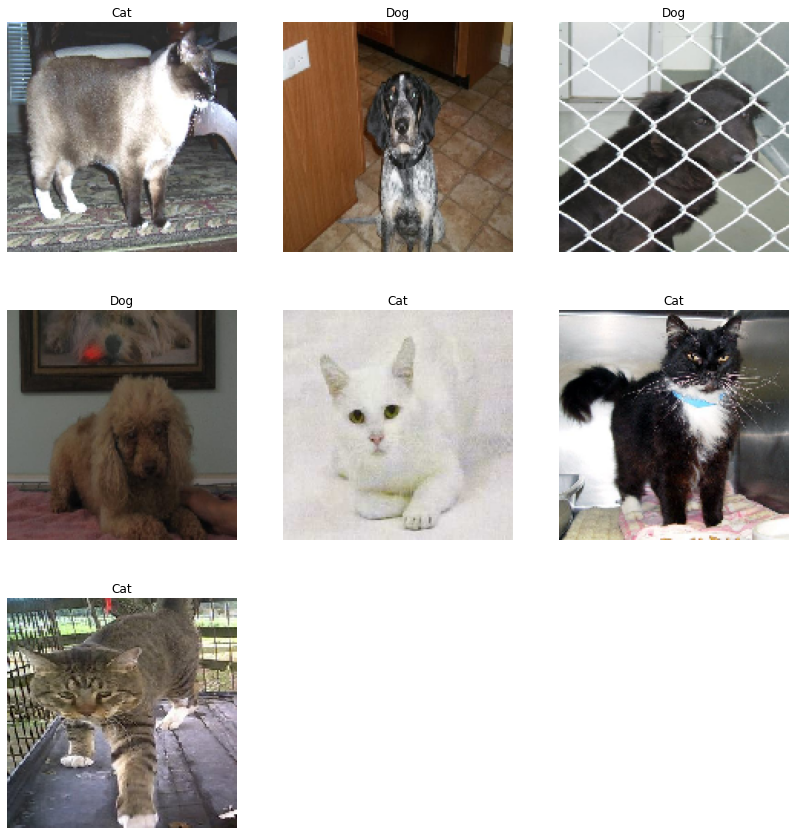

In [15]:
class_names = ['Cat', 'Dog']

# Use the generator to sample a few images with their class names
def plot_data(generator, n_images):
    i = 0
    plt.figure(figsize=(14, 15))
    for batch in generator:
        images, labels = batch
        labels = labels.astype('int32')
        for image, label in zip(images, labels):
            if i >= n_images:
                break
            plt.subplot((n_images // 3) + 1, 3, i + 1)
            plt.imshow(image)
            plt.title(class_names[label])
            plt.axis('off')
            i += 1
        if i >= n_images:
            break
    plt.show()


plot_data(train_generator, 7)

## Training Model

In [11]:
def train_model():
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    r = model.fit(
        train_generator,
        epochs=3,
        validation_data=validation_generator)
    return [model, r]


[model, r] = train_model()

Epoch 1/3
289/289 [==============================] - 348s 1s/step - loss: 0.7093 - accuracy: 0.6084 - val_loss: 0.6462 - val_accuracy: 0.6316
Epoch 2/3
289/289 [==============================] - 338s 1s/step - loss: 0.6445 - accuracy: 0.6388 - val_loss: 0.5876 - val_accuracy: 0.6832
Epoch 3/3
289/289 [==============================] - 1562s 5s/step - loss: 0.5967 - accuracy: 0.6901 - val_loss: 0.5501 - val_accuracy: 0.7300


In [16]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

17/17 [==============================] - 5s 317ms/step - loss: 0.5501 - accuracy: 0.7300


2/2 [==============================] - 0s 156ms/step


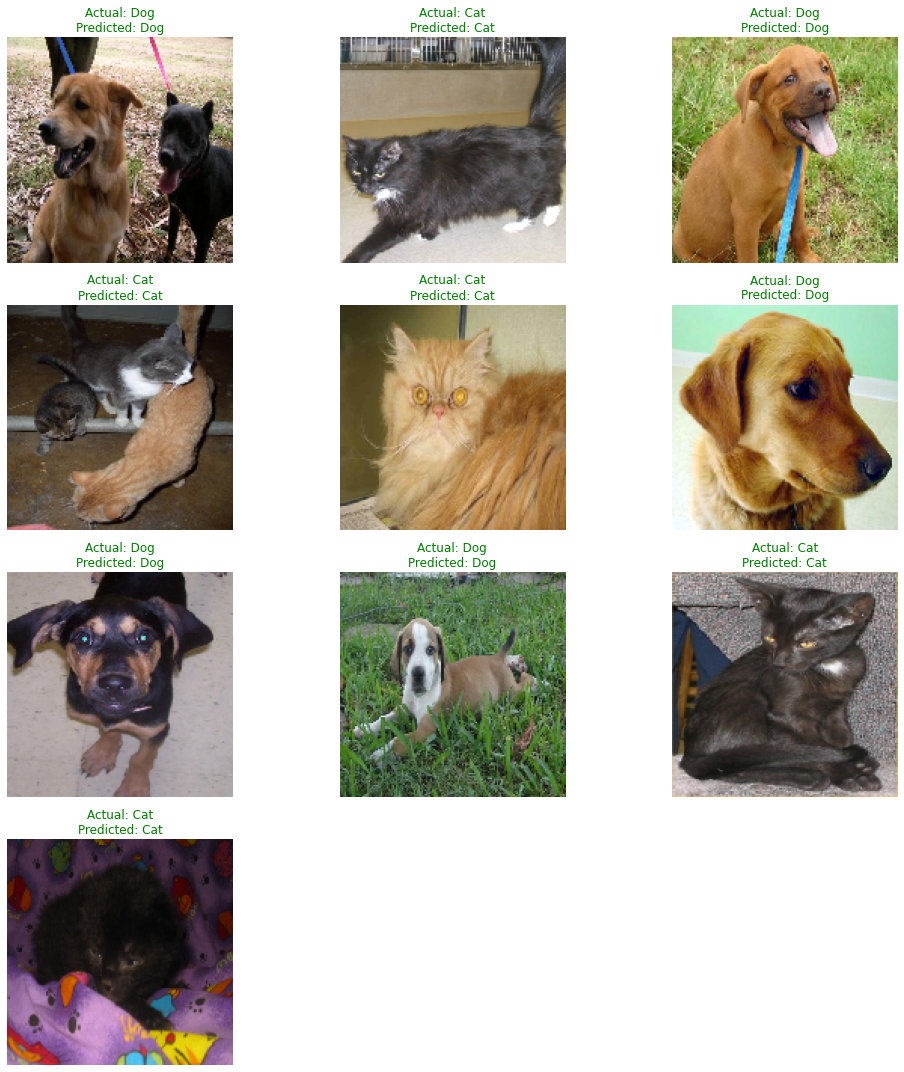

In [63]:
def plot_prediction(generator, n_images):
    i = 0 
    images, labels = generator.next()
    predictions = model.predict(images)
    predictions = np.argmax(predictions, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i + 1)
        plt.imshow(image)
        actual_label = class_names[label]
        predicted_label = class_names[predictions[i]]
        
        if predictions[i] == labels[i]:
            title_color = 'g'
        else:
            title_color = 'r'
        
        title_obj = plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.setp(title_obj, color=title_color)
        plt.axis('off')
        
        i += 1
        if i == n_images:
            break
    
    plt.tight_layout()
    plt.show()

if INCLUDE_TEST:
    plot_prediction(test_generator, 10)


2/2 [==============================] - 0s 155ms/step


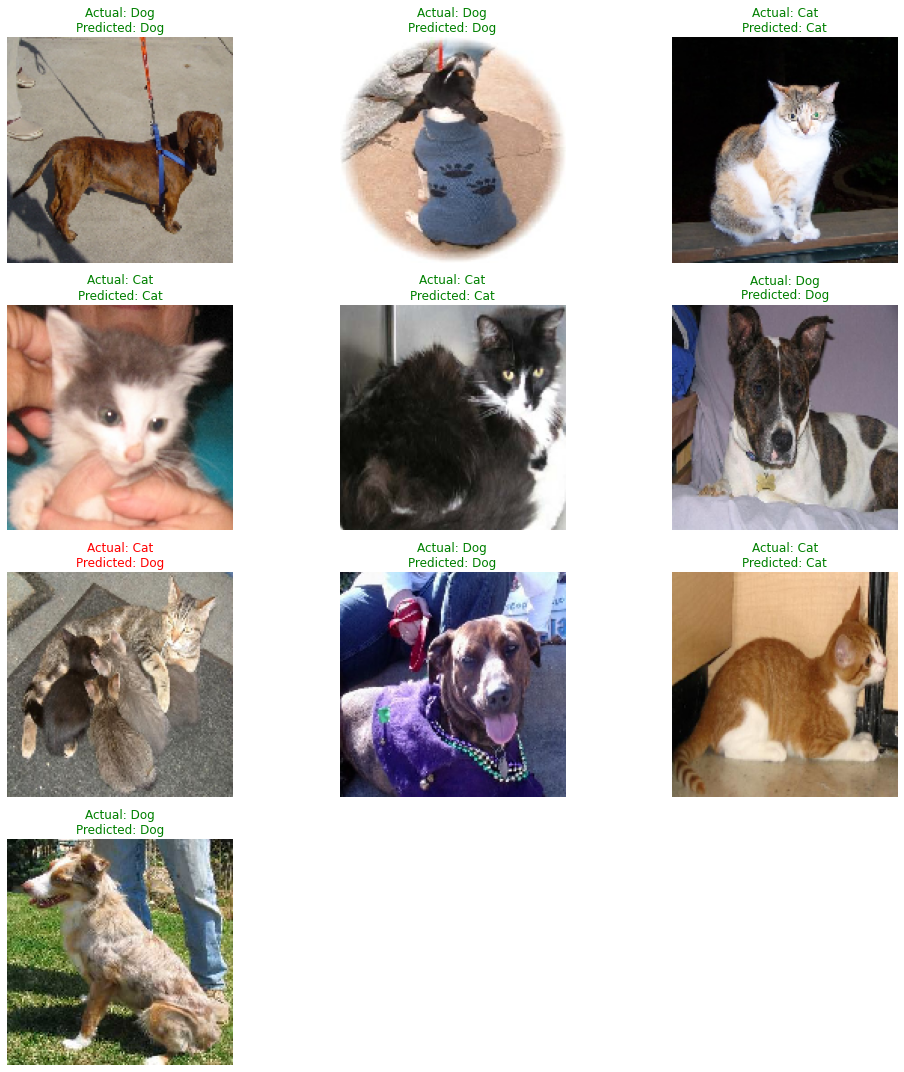

In [24]:
plot_prediction(validation_generator, 10)

In [116]:
# Print details about the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 128)       73856     
                                                           

2/2 [==============================] - 0s 193ms/step


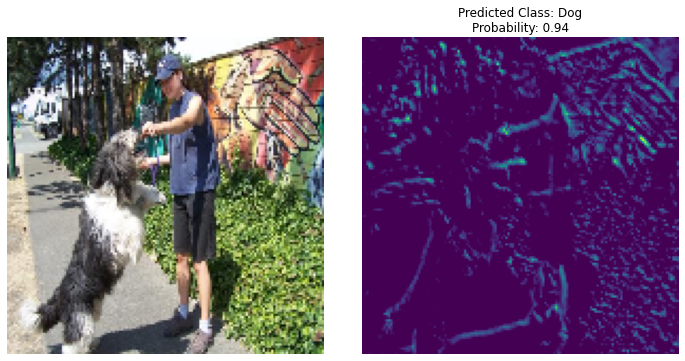

In [115]:
conv_layer_name = 'conv2d_7'
activation_model = Model(inputs=model.input, 
                         outputs=[model.get_layer('conv2d_7').output, model.get_layer('dense_3').output])
images, _ = test_generator.next()
activations, results = activation_model.predict(images)

def show_activations(image_index, activations, results, images, class_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(images[image_index])
    ax1.axis('off')
    
    ax2.imshow(activations[image_index, :, :, 0], cmap='viridis')
    ax2.axis('off')
    prediction = np.argmax(results[image_index])
    probability = results[image_index][prediction]
    predicted_class = class_names[prediction]
    
    ax2.set_title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}', fontsize=12)
    plt.tight_layout()
    plt.show()

class_names = ['Cat', 'Dog']
show_activations(0, activations, results, images, class_names)

## Visualize Training Process

In [65]:
results = pd.DataFrame(r.history)
results.tail()

,loss,accuracy,val_loss,val_accuracy
0,0.709307,0.608359,0.646240,0.631579
1,0.644549,0.638839,0.587570,0.683236
2,0.596724,0.690055,0.550142,0.730020


In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

## Data Augmentation

In [117]:
train_gen_aug = ImageDataGenerator(
    rescale=1./255, fill_mode='nearest', horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug = ImageDataGenerator(
    rescale=1./255.)


train_generator = train_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=x)

model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

r = model_aug.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

results = pd.DataFrame(r.history)
results.tail()


fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

Found 18471 images belonging to 2 classes.
Found 1026 images belonging to 2 classes.


Epoch 1/10
 23/578 [>.............................] - ETA: 7:13 - loss: 2.0986 - accuracy: 0.5938

KeyboardInterrupt: 

In [ ]:
r = model_aug.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)


results = pd.DataFrame(r.history)
results.tail()


fig = px.line(results, y=[results['accuracy'], results['val_accuracy']],
              template="seaborn", color_discrete_sequence=['#fad25a', 'red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title='Epochs'),
    yaxis=dict(color="#fad25a")
)
fig.show()

## Saving

In [118]:
save_dir = './'
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_path = os.path.join(save_dir, 'pet_classifier.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ./my_model.h5


## Loading

In [120]:
loaded_model = tf.keras.models.load_model('./pet_classifier.h5')
loaded_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 128)       73856     
                                                           

## References
- https://www.kaggle.com/code/fareselmenshawii/cats-vs-dogs-classification/notebook